In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

In [43]:
%pip install torchsummary
from torchsummary import summary

Note: you may need to restart the kernel to use updated packages.


In [45]:
train_transforms = transforms.Compose([
                                        transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                        transforms.RandomApply(torch.nn.ModuleList([

                                          transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
                                          transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),

                                        ]), p=0.2),
                                        transforms.ToTensor(),
#                                         transforms.Normalize((0.4784, 0.4691, 0.4345), (0.2099, 0.2069, 0.2063))
                                      ])

test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
#                                         transforms.Normalize((0.4784, 0.4691, 0.4345), (0.2099, 0.2069, 0.2063))
                                    ])

In [46]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [47]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [48]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

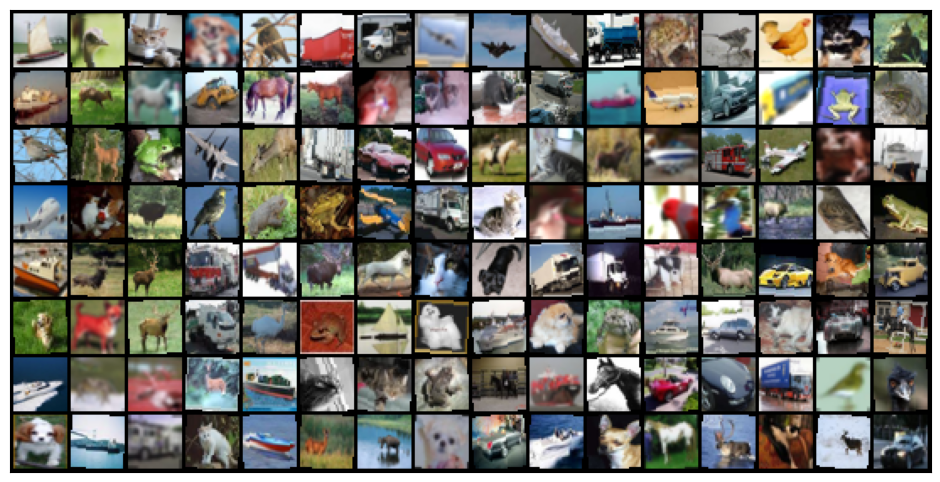

In [49]:
show_batch(train_loader)

In [74]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv0 = self.make_conv(inchannels=3, outchannels=16, kernel=3, padding=1, dropout=0)    
        self.conv1 = self.make_conv(inchannels=16, outchannels=16, kernel=3, padding=1, dropout=0.2) 
        self.conv2 = self.make_conv(inchannels=16, outchannels=8, kernel=1, padding=0, dropout=0) 
        
        self.max_pool0 = nn.MaxPool2d(kernel_size=(2, 2))      

        self.conv3 = self.make_conv(inchannels=8, outchannels=16, kernel=3, padding=1, dropout=0.2)
        self.conv4 = self.make_conv(inchannels=16, outchannels=16, kernel=3, padding=1, dropout=0.2)
        self.conv5 = self.make_conv(inchannels=16, outchannels=8, kernel=1, padding=0, dropout=0)  

        self.max_pool1 = nn.MaxPool2d(kernel_size=(2, 2))

        self.conv6 = self.make_conv(inchannels=8, outchannels=64, kernel=3, padding=1, dropout=0.3) 
        self.conv7 = self.make_conv(inchannels=64, outchannels=64, kernel=3, padding=1, dropout=0.3)
        self.conv8 = self.make_conv(inchannels=64, outchannels=16, kernel=1, padding=0, dropout=0)   

        self.gap = nn.AvgPool2d(kernel_size=4) 
        
        self.conv9 = nn.Sequential(

             nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(2, 2), padding=0) 

        )

    def make_conv(self, inchannels, outchannels, kernel, padding, dropout):
        
        layers = []
        layers.append(nn.Conv2d(in_channels=inchannels, out_channels=outchannels, kernel_size=kernel, padding=padding))
        layers.append(nn.GELU())
        
        if kernel != 1:
            layers.append(nn.BatchNorm2d(outchannels))
            layers.append(nn.Dropout(dropout))
        
        return nn.Sequential(*layers)
        

    def forward(self, x):

        x = self.conv0(x)
        x = self.conv1(x)
        x = self.conv2(x)

        x = self.max_pool0(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.max_pool1(x)

        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        
        x = self.gap(x)

        x = self.conv9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [75]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              GELU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           2,320
              GELU-6           [-1, 16, 32, 32]               0
       BatchNorm2d-7           [-1, 16, 32, 32]              32
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             136
             GELU-10            [-1, 8, 32, 32]               0
        MaxPool2d-11            [-1, 8, 16, 16]               0
           Conv2d-12           [-1, 16, 16, 16]           1,168
             GELU-13           [-1, 16, 16, 16]               0
      BatchNorm2d-14           [-1

In [76]:
train_acc = []
train_loss = []
test_acc = []
test_losses = []

def train(model, device, train_loader, optimizer, epoch):

    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0

    for batch, (data, target) in enumerate(pbar):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        y_pred = model(data)

        loss = F.nll_loss(y_pred, target)

        loss.backward()
        optimizer.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

def test(model, device, test_loader):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:

            data, target = data.to(device), target.to(device)
            y_pred = model(data)

            loss = F.nll_loss(y_pred, target, reduction='sum').item()
            pred = y_pred.argmax(dim=1, keepdim=True)

            correct += pred.eq(target.view_as(pred)).sum().item()

            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)

            test_acc.append(100. * correct / len(test_loader.dataset))

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

In [77]:
model =  Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

EPOCHS = 20
for epoch in range(EPOCHS):

    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.536370038986206 Batch_id=390 Accuracy=38.34: 100%|██████████| 391/391 [00:13<00:00, 29.54it/s] 



Test set: Average loss: 0.0000, Accuracy: 4796/10000 (47.96%)

EPOCH: 1


Loss=1.511474847793579 Batch_id=390 Accuracy=50.95: 100%|██████████| 391/391 [00:12<00:00, 30.89it/s] 



Test set: Average loss: 0.0000, Accuracy: 5715/10000 (57.15%)

EPOCH: 2


Loss=0.9222993850708008 Batch_id=390 Accuracy=56.52: 100%|██████████| 391/391 [00:13<00:00, 29.77it/s]



Test set: Average loss: 0.0000, Accuracy: 6010/10000 (60.10%)

EPOCH: 3


Loss=1.3334113359451294 Batch_id=390 Accuracy=59.22: 100%|██████████| 391/391 [00:12<00:00, 30.58it/s]



Test set: Average loss: 0.0000, Accuracy: 6317/10000 (63.17%)

EPOCH: 4


Loss=0.9582334756851196 Batch_id=390 Accuracy=61.28: 100%|██████████| 391/391 [00:12<00:00, 30.56it/s]



Test set: Average loss: 0.0000, Accuracy: 6509/10000 (65.09%)

EPOCH: 5


Loss=0.8609123229980469 Batch_id=390 Accuracy=62.63: 100%|██████████| 391/391 [00:13<00:00, 29.89it/s]



Test set: Average loss: 0.0000, Accuracy: 6567/10000 (65.67%)

EPOCH: 6


Loss=1.002489447593689 Batch_id=390 Accuracy=63.84: 100%|██████████| 391/391 [00:12<00:00, 30.98it/s] 



Test set: Average loss: 0.0000, Accuracy: 6746/10000 (67.46%)

EPOCH: 7


Loss=0.9200627207756042 Batch_id=390 Accuracy=64.58: 100%|██████████| 391/391 [00:12<00:00, 30.27it/s]



Test set: Average loss: 0.0000, Accuracy: 6606/10000 (66.06%)

EPOCH: 8


Loss=0.8951776623725891 Batch_id=390 Accuracy=65.56: 100%|██████████| 391/391 [00:12<00:00, 31.15it/s]



Test set: Average loss: 0.0000, Accuracy: 6491/10000 (64.91%)

EPOCH: 9


Loss=0.7262486219406128 Batch_id=390 Accuracy=66.23: 100%|██████████| 391/391 [00:13<00:00, 29.99it/s]



Test set: Average loss: 0.0000, Accuracy: 6964/10000 (69.64%)

EPOCH: 10


Loss=0.784683883190155 Batch_id=390 Accuracy=66.97: 100%|██████████| 391/391 [00:12<00:00, 31.34it/s] 



Test set: Average loss: 0.0000, Accuracy: 6997/10000 (69.97%)

EPOCH: 11


Loss=0.8499482870101929 Batch_id=390 Accuracy=67.28: 100%|██████████| 391/391 [00:12<00:00, 30.88it/s]



Test set: Average loss: 0.0000, Accuracy: 6813/10000 (68.13%)

EPOCH: 12


Loss=0.7687657475471497 Batch_id=390 Accuracy=68.22: 100%|██████████| 391/391 [00:12<00:00, 30.37it/s]



Test set: Average loss: 0.0000, Accuracy: 7066/10000 (70.66%)

EPOCH: 13


Loss=0.8129425048828125 Batch_id=390 Accuracy=68.28: 100%|██████████| 391/391 [00:12<00:00, 30.16it/s]



Test set: Average loss: 0.0000, Accuracy: 7125/10000 (71.25%)

EPOCH: 14


Loss=0.933295726776123 Batch_id=390 Accuracy=68.66: 100%|██████████| 391/391 [00:13<00:00, 29.41it/s] 



Test set: Average loss: 0.0000, Accuracy: 7250/10000 (72.50%)

EPOCH: 15


Loss=0.9350678324699402 Batch_id=390 Accuracy=69.45: 100%|██████████| 391/391 [00:12<00:00, 30.19it/s]



Test set: Average loss: 0.0000, Accuracy: 7252/10000 (72.52%)

EPOCH: 16


Loss=1.017710566520691 Batch_id=390 Accuracy=69.63: 100%|██████████| 391/391 [00:13<00:00, 29.61it/s] 



Test set: Average loss: 0.0000, Accuracy: 7160/10000 (71.60%)

EPOCH: 17


Loss=1.2035644054412842 Batch_id=390 Accuracy=70.06: 100%|██████████| 391/391 [00:12<00:00, 30.23it/s]



Test set: Average loss: 0.0000, Accuracy: 7259/10000 (72.59%)

EPOCH: 18


Loss=1.058364748954773 Batch_id=390 Accuracy=70.57: 100%|██████████| 391/391 [00:12<00:00, 30.27it/s] 



Test set: Average loss: 0.0000, Accuracy: 7121/10000 (71.21%)

EPOCH: 19


Loss=0.8020679354667664 Batch_id=390 Accuracy=70.60: 100%|██████████| 391/391 [00:12<00:00, 30.25it/s]



Test set: Average loss: 0.0000, Accuracy: 6992/10000 (69.92%)

